![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Total least-squares DMD

The total least-squares DMD (TDMD) was first introduced by M. S. Hemati et al. in [De-biasing the dynamic mode decomposition for applied Koopman spectral analysis of noisy datasets](https://link.springer.com/article/10.1007/s00162-017-0432-2).

In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.analysis import DMD

# increase resolution of plots
plt.rcParams['figure.dpi'] = 160

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(DATASETS["of_cylinder2D_binary"])
window_times = [time for time in loader.write_times if float(time) >= 6.0]
times_num = pt.tensor([float(time) for time in window_times])

In [3]:
vertices = loader.vertices
weights = loader.weights
vort = loader.load_snapshot("vorticity", window_times)
vort = vort[:, 2, :]

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


In [4]:
def add_noise_to_data(data: pt.Tensor, level: float) -> pt.Tensor:
    if len(data.shape) > 2:
        noisy_data = pt.zeros_like(data)
        shape = (data.shape[0], data.shape[-1])
        for i in range(data.shape[1]):
            val_range = (data[:, i, :].max() - data[:, i, :].min()) * level
            noisy_data[:, i, :] = data[:, i, :] + val_range * 2 * (pt.rand(shape) - 0.5)
        return noisy_data
    else:
        val_range = (data.max() - data.min()) * level
        return data + val_range * 2 * (pt.rand(data.shape) - 0.5)

In [5]:
vort_noisy = add_noise_to_data(vort, 0.05)

In [6]:
mask = mask_box(vertices, [0.0, -1.0, -1.0], [1.0, 1.0, 1.0])
n_points = mask.sum().item()
dm = pt.zeros((n_points, len(window_times)))
dm_noisy = pt.zeros_like(dm)

for i in range(len(window_times)):
    dm[:, i] = pt.masked_select(vort[:, i], mask)
    dm_noisy[:, i] = pt.masked_select(vort_noisy[:, i], mask)

In [7]:
dt = times_num[1] - times_num[0]
rank = 10
dmd = DMD(dm, dt, rank=rank, optimal=True)
dmd_noisy = DMD(dm_noisy, dt, rank=rank, optimal=True)
tdmd_noisy = DMD(dm_noisy, dt, rank=rank, optimal=True, tlsq=True)
print(dmd, dmd_noisy, tdmd_noisy)

SVD:
SVD of a 9608x10 data matrix
Selected/optimal rank: 10/62
data type: torch.float32 (4b)
truncated SVD size: 381.6016Kb
LSQ:
Overall DMD size: 1.1065Mb SVD:
SVD of a 9608x10 data matrix
Selected/optimal rank: 10/5
data type: torch.float32 (4b)
truncated SVD size: 381.6016Kb
LSQ:
Overall DMD size: 1.1065Mb SVD:
SVD of a 9608x10 data matrix
Selected/optimal rank: 10/11
data type: torch.float32 (4b)
truncated SVD size: 381.6016Kb
LSQ:
Overall DMD size: 1.1065Mb


In [8]:
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

def add_field(ax, field, title, every=4):
    ax.tricontourf(x[::every], y[::every], field[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], field[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)

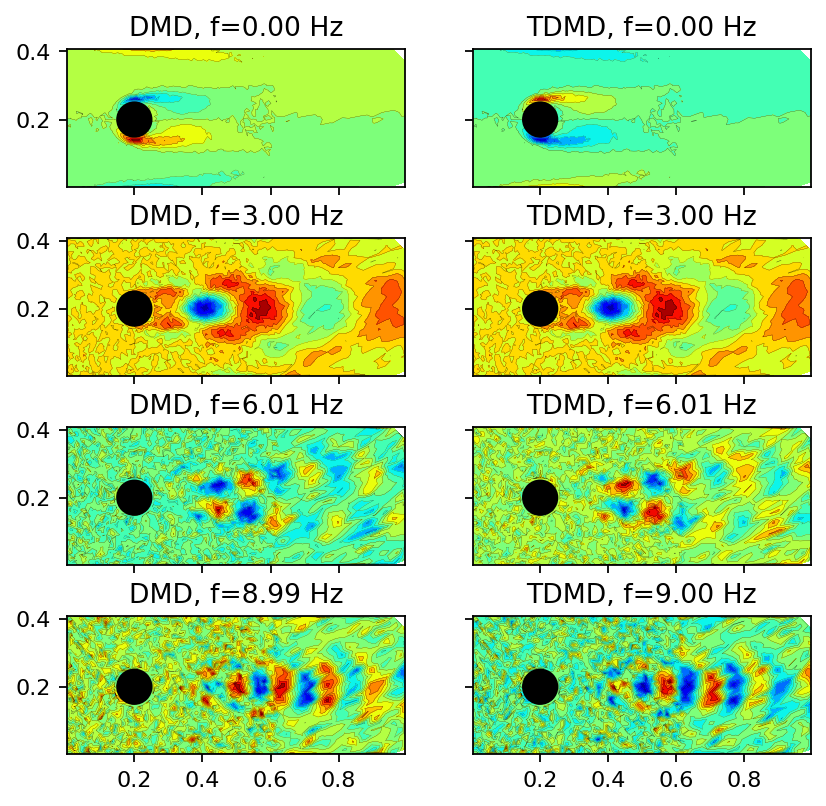

In [9]:
top_dmd = dmd_noisy.top_modes(7, integral=True)
top_dmd = top_dmd[dmd_noisy.frequency[top_dmd] >= 0]
top_tdmd = tdmd_noisy.top_modes(7, integral=True)
top_tdmd = top_tdmd[tdmd_noisy.frequency[top_tdmd] >= 0]

assert top_dmd.shape == top_dmd.shape
n_modes = top_dmd.shape[0]

fig, axarr = plt.subplots(n_modes, 2, figsize=(6, 1.5*n_modes), sharex=True, sharey=True)
for row, (m, tm) in enumerate(zip(top_dmd, top_tdmd)):
    add_field(axarr[row, 0], dmd_noisy.modes[:, m].real, f"DMD, f={dmd_noisy.frequency[m]:2.2f} Hz")
    add_field(axarr[row, 1], tdmd_noisy.modes[:, tm].real, f"TDMD, f={tdmd_noisy.frequency[tm]:2.2f} Hz")
plt.show()

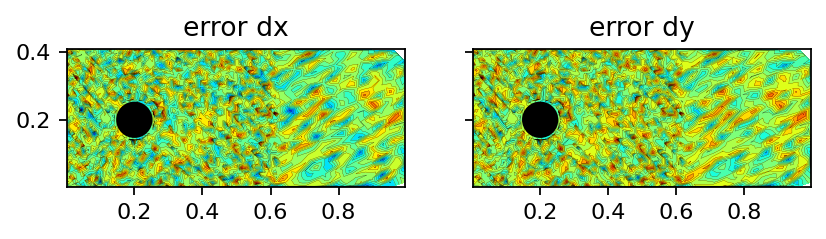

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

dx, dy = tdmd_noisy.tlsq_error
add_field(ax1, dx.norm(dim=1), f"error dx")
add_field(ax2, dy.norm(dim=1), f"error dy")
plt.show()

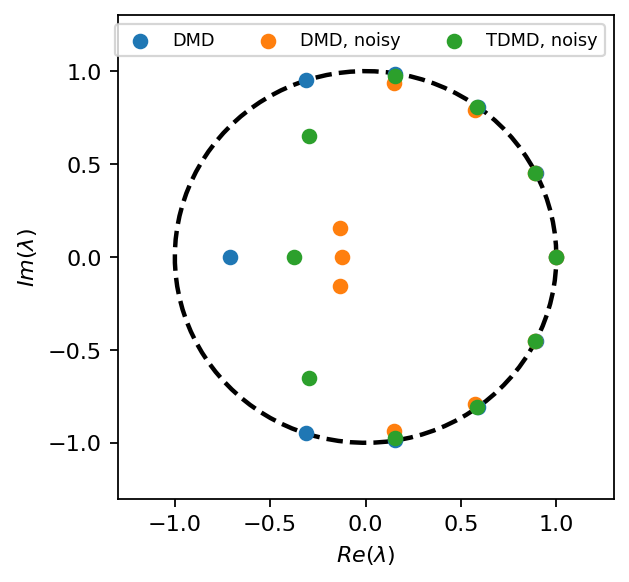

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, zorder=7, label="DMD")
ax.scatter(dmd_noisy.eigvals.real, dmd_noisy.eigvals.imag, zorder=7, label="DMD, noisy")
ax.scatter(tdmd_noisy.eigvals.real, tdmd_noisy.eigvals.imag, zorder=7, label="TDMD, noisy")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
ax.legend(ncol=3, fontsize=8)
plt.show()